# Inferer for Hazus Earthquake Damage and Loss Analysis Workflow

Written by yisangriB, fmk

Dec 19, 2024

This example demonstrates the final step of Brails++ workflow, which filters in the final feature set that is readily importable in R2D (or Pelicun). For this, a target regional simulation workflow needs to first be specified. In this example, we chose the **Hazus Earthquake Damage and Loss assessment** workflow. 

Below are six features needed to run **Hazus Earthquake (EQ) Damage and Loss assessment** workflow using R2D .

| DL functions             | Feature key                               |
|--------------------------|-------------------------------------------|
| Building Hazus EQ Damage | StructuralType, BuildingRise, DesignLevel, FoundationType |
| Building Hazus EQ Loss   | ReplacementCost, OccupancyClass           |


Some features available from NSI, such as StructureType, RepairCost, NumberOfStories, YearBuilt, and OccupancyClass, can be translated to these six features, using the inferer named **Infer_features_for_HazusDL**

The outcome inventory can be saved into either a geojson file or a csv file and be readily imported in R2D.



In [29]:
# Written: sy Dec 2024
# License: BSD-2

"""
 Purpose: Testing Inferer
"""

# Install packages. They are used only for the map visualization 
try:
    import folium
except Exception as e:
    import sys
    !{sys.executable} -m pip install folium
    import folium

try:
    import plotly.express as px
except Exception as e:
    import sys
    !{sys.executable} -m pip install plotly
    import plotly.express as px

import os
import sys
import copy
import json
import gc # to collect memory

import numpy as np

sys.path.insert(0, "../../")
from brails.utils import Importer
from brails.types.image_set import ImageSet    
from brails.types.asset_inventory import Asset, AssetInventory


## Step1: Set the regional boundary by its name

Target city is Berkeley, CA

In [30]:
region_data = {"type": "locationName", "data": "Berkeley, CA"}

In [31]:
importer = Importer()
region_boundary_class = importer.get_class("RegionBoundary")
region_boundary_object = region_boundary_class(region_data)


Searching for Berkeley, CA...
Found Berkeley, Alameda County, California, United States


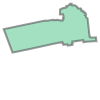

In [32]:
#visualize the regional bound
bound = region_boundary_object.get_boundary()
bound[0]

Set the target number of possible worlds

In [33]:
n_pw = 1

## Step2: Obtain baseline inventory data by marging OSM foot print with NSI database

In [34]:
# Scrape NSI database
nsi_class = importer.get_class('NSI_Parser')
nsi = nsi_class()
nsi_inventory = nsi.get_raw_data_given_boundary(region_boundary_object, 'ft')

print('Total number of assets detected using NSI is '
      f'{len(nsi_inventory.inventory)}')


Searching for Berkeley, CA...
Found Berkeley, Alameda County, California, United States

Getting National Structure Inventory (NSI) building data for the entered location input...
Found a total of 27706 building points in NSI that are within the entered region of interest
Total number of assets detected using NSI is 27706


In [35]:
# Scrape the building inventory from OSM:
scraper_class = importer.get_class('OSM_FootprintScraper')
scraper = scraper_class({'length': 'ft'})
scraper_inventory = scraper.get_footprints(region_boundary_object)


Searching for Berkeley, CA...
Found Berkeley, Alameda County, California, United States

Found a total of 35577 building footprints in Berkeley


In [36]:
# Merge these footprints with the NSI raw data previously downloaded:
# Remeber to set "get_extended_features" to true to get split-level and basement information - this will be used in Section 5
new_inventory = nsi.get_filtered_data_given_inventory(scraper_inventory, "ft", get_extended_features=True)


Getting National Structure Inventory (NSI) building data for the entered location input...
Found a total of 26277 building points in NSI that match the footprint data.


In [37]:
print("Asset id=6, After Merging NSI and OSM")
new_inventory.get_asset_features(6)[1]  # empty or 'NA' are missing values

Asset id=6, After Merging NSI and OSM


{'type': 'Building',
 'buildingheight': 'NA',
 'erabuilt': 1939,
 'numstories': 1,
 'roofshape': 'NA',
 'fpAreas': 17200,
 'lon': -122.2603455,
 'lat': 37.873551283,
 'fparea': 18699,
 'repaircost': 0,
 'constype': 'C1',
 'occupancy': 'EDU2',
 'fd_id': 473587479,
 'splitlevel': 'No',
 'basement': 'NA'}

## Step 3. Run imputation to fill in missing values

Imputer fills in missing values when a feature is available for a subset of buildings in a region but not for all buildings, and it imputes the values by assuming a similarity between neighboring buildings. Therefore, the assumption is that the feature is available at least for a subset of buildings, and those buildings provide reliable information of the neighboring buildings.

If a feature is completely missing for the entire building stock in the area, that feature cannot be 'imputed.' Such features may be 'inferred' using external rulesets (Hazus or user-provided). See Step 5 for more details.

### Importing imputer and run imputation

In [38]:
importer = Importer()
knn_imputer_class = importer.get_class("KnnImputer")

imputer=knn_imputer_class(new_inventory,n_possible_worlds=n_pw,exclude_features=['lat','lon','fd_id'])
new_inventory = imputer.impute()

Missing percentages among 35577 assets
buildingheight: 99.97%
erabuilt: 26.13%
numstories: 24.91%
roofshape: 99.38%
fparea: 26.14%
repaircost: 26.14%
constype: 26.14%
occupancy: 26.14%
splitlevel: 26.14%
basement: 52.24%
Primitive imputation done.
Running the main imputation. This may take a while.
Enumerating clusters: 20 among 71
Enumerating clusters: 40 among 71
Enumerating clusters: 60 among 71
Done imputation. It took 0.27 mins


In [39]:
print("Asset id=6, After imputation")
new_inventory.get_asset_features(6)[1]  # empty or 'NA' are missing values

Asset id=6, After imputation


{'type': 'Building',
 'buildingheight': 45.9,
 'erabuilt': 1939,
 'numstories': 1,
 'roofshape': 'gabled',
 'fpAreas': 17200,
 'lon': -122.2603455,
 'lat': 37.873551283,
 'fparea': 18699,
 'repaircost': 0,
 'constype': 'C1',
 'occupancy': 'EDU2',
 'fd_id': 473587479,
 'splitlevel': 'No',
 'basement': 'Yes'}

## Step 4. Collect Income information (Let's randomly generate it for now)

At this point, Brails ++ does not automatically scrape the household income information. The user can import it from a CSV file or use a user-defined inferer to augment the information.
For now, let's just randomly generate it from a lognormal distribution. The income information source will be integrated into brails++ in the future. 

In [40]:
# Temporary add incomes
import numpy as np

cal_avg = 78672 # state average
std_dev = cal_avg*0.5 # 50% cov

mean_original = cal_avg     # Mean in the original space (lognormal)
std_dev_original = std_dev     # Standard deviation in the original space (lognormal)
sample_size = 1         # Number of samples to generate
# Step 1: Calculate the parameters of the underlying normal distribution
mu = np.log(mean_original**2 / np.sqrt(std_dev_original**2 + mean_original**2))
sigma = np.sqrt(np.log(1 + (std_dev_original**2 / mean_original**2)))

# Step 2: Generate the lognormal sample using the parameters of the normal distribution
for key, val in new_inventory.inventory.items():
    lognormal_sample = np.random.lognormal(mean=mu, sigma=sigma, size=sample_size)
    val.add_features({"Income":lognormal_sample[0]})
 

In [41]:
print("Asset id=6, After adding income")
new_inventory.get_asset_features(6)[1]  # empty or 'NA' are missing values

Asset id=6, After adding income


{'type': 'Building',
 'buildingheight': 45.9,
 'erabuilt': 1939,
 'numstories': 1,
 'roofshape': 'gabled',
 'fpAreas': 17200,
 'lon': -122.2603455,
 'lat': 37.873551283,
 'fparea': 18699,
 'repaircost': 0,
 'constype': 'C1',
 'occupancy': 'EDU2',
 'fd_id': 473587479,
 'splitlevel': 'No',
 'basement': 'Yes',
 'Income': 123101.26165905621}

## Step 5. Basic inference using NSI data

Recall that below are six features that are needed to run Hazus EQ Damage and Loss assessment workflow using R2D (Pelican).

| DL functions          | Feature key                               |
|-----------------------|-------------------------------------------|
| Building Hazus EQ Damage | StructuralType, BuildingRise, DesignLevel, FoundationType |
| Building Hazus EQ Loss   | ReplacementCost, OccupancyClass           |


Among the six features, 
* **StructuralType, ReplacementCost, OccupancyClass** are already provided from NSI, so we need to simply change their key names.
* **BuildingRise, DesignLevel, FoundationType** require a simple deterministic inference, taking NumberOfStories, YearBuilt, and StructuralType as inputs

The inferer module named **Infer_features_for_HazusDL** will take care of both tasks as follows


In [42]:
# existing key names
structureType_key = 'constype'
replacementCost_key = 'repaircost'
numberOfStories_key = 'numstories'
yearBuilt_key = 'erabuilt'
occupancyClass_key = 'occupancy'

In [43]:
Infer_features_for_HazusDL2 = importer.get_class("Infer_features_for_HazusDL")
inferer=Infer_features_for_HazusDL2(input_inventory=new_inventory, 
                                n_possible_worlds=n_pw, 
                                yearBuilt_key = yearBuilt_key, 
                                occupancyClass_key = occupancyClass_key, 
                                numberOfStories_key = numberOfStories_key, 
                                structureType_key = structureType_key,
                                replacementCost_key = replacementCost_key,
                                clean_features= True)
new_inventory_HazusDL = inferer.infer()

>> Step1 : Checking if OccupancyClass (occupancy) exist.
>> Step2-1 : Checking if StructureType (constype) and ReplacementCost (repaircost) exist
>> Step3-1 : Checking if BuildingRise (BuildingRise), DesignLevel (DesignLevel) and FoundationType (FoundationType) exist
>> Step3-2 : Inferring {'DesignLevel', 'FoundationType', 'BuildingRise'}
>> Step4 : Changing feature names to what R2D (pelicun) can recognize
Done inference. It took 0.14 mins


In [44]:
print("Asset id=6, After ruuning Inferer")
new_inventory_HazusDL.get_asset_features(6)[1]  # empty or 'NA' are missing values

Asset id=6, After ruuning Inferer


{'StructureType': 'C1',
 'BuildingRise': 'L',
 'DesignLevel': 'LC',
 'FoundationType': 'S',
 'ReplacementCost': 0,
 'OccupancyClass': 'EDU2'}

Note that the replacement cost of this building obtained from NSI is zero. If you think this is not reliable, you can also utilize Hazus inferer to improve this. See below.

## Step 5 (alternative). Run advanced inference using Hazus rulesets

Alternativly, one can additionally estimate **StructuralType** and/or **ReplacementCost** using rulesets provided in the Hazus inventory manual 6, instead of relying on NSI dataset. This is particularly useful when user have a more reliable, high-resolution local/private data sources (e.g. for YearBuilt, Income, NumberOfStories etc.) that may provide a better information to evaluate the **StructuralType** and **ReplacementCost**. To enable this feature, provide "new" key names for these two features.


In [45]:
# The names of NEW keys to be infered.
structureType_key = 'StructureTypeHazus' # instead of  "constype" from NSI
replacementCost_key = 'ReplacementCostHazus' # instead of "repaircost" from NSI

# The names of existing keys to be used as "predictors"
yearBuilt_key = 'erabuilt'
occupancyClass_key = 'occupancy'
income_key = 'Income'
numberOfStories_key = 'numstories'
planArea_key = 'fpAreas'
splitLevel_key = 'splitlevel'


Note that only if these keys for **StructuralType** and **ReplacementCost** don't exist in the current inventory file, the module will automatically infer it. To make the inference, additional inventory is needed, such as **Income**, **PlanArea**, and **SplitLevel**. See the user manual to understand what feature keys need to be included as predictors to infer what feature.

In [46]:
Infer_features_for_HazusDL = importer.get_class("Infer_features_for_HazusDL")
inferer=Infer_features_for_HazusDL(input_inventory=new_inventory, 
                                n_possible_worlds=n_pw, 
                                yearBuilt_key = yearBuilt_key, 
                                occupancyClass_key = occupancyClass_key, 
                                numberOfStories_key = numberOfStories_key, 
                                income_key=income_key, 
                                splitLevel_key = splitLevel_key,
                                structureType_key = structureType_key,
                                replacementCost_key = replacementCost_key,
                                planArea_key=planArea_key,
                                clean_features= False)
new_inventory_HazusDL2 = inferer.infer()

>> Step1 : Checking if OccupancyClass (occupancy) exist.
>> Step2-1 : Checking if StructureType (StructureTypeHazus) and ReplacementCost (ReplacementCostHazus) exist
>> Step2-2 : Inferring {'StructureTypeHazus', 'ReplacementCostHazus'}


GarageType info not found in the inventory. Making inference using Hazus 6.
ConstructionClass info not found in the inventory. Making inference using Hazus 6.
Done inference. It took 0.15 mins
>> Step3-1 : Checking if BuildingRise (BuildingRise), DesignLevel (DesignLevel) and FoundationType (FoundationType) exist
>> Step3-2 : Inferring {'DesignLevel', 'FoundationType', 'BuildingRise'}


The feature StructureTypeHazus is missing in many buildings including:  [120, 122, 184, 276, 504, 602, 653, 693, 985, 1338]
>> Step4 : Changing feature names to what R2D (pelicun) can recognize
Done inference. It took 0.27 mins


In [47]:
new_inventory_HazusDL2.get_asset_features(6)[1]  # empty or 'NA' are missing values

{'type': 'Building',
 'buildingheight': 45.9,
 'erabuilt': 1939,
 'numstories': 1,
 'roofshape': 'gabled',
 'fpAreas': 17200,
 'lon': -122.2603455,
 'lat': 37.873551283,
 'fparea': 18699,
 'repaircost': 0,
 'constype': 'C1',
 'fd_id': 473587479,
 'splitlevel': 'No',
 'basement': 'Yes',
 'Income': 123101.26165905621,
 'StructureType': 'RM1',
 'BuildingRise': 'L',
 'FoundationType': 'S',
 'ReplacementCost': 3390120.0,
 'OccupancyClass': 'EDU2'}

Some instances of **StructuralType**  are missing in the final attributes. As instructed by the warning msg, let's do some imputation

In [48]:
imputer=knn_imputer_class(new_inventory_HazusDL2,n_possible_worlds=n_pw)
new_inventory_HazusDL2_imputed = imputer.impute()

Missing percentages among 35577 assets
lon: 26.14%
lat: 26.14%
fd_id: 26.14%
StructureType: 0.09%
Primitive imputation done.
Running the main imputation. This may take a while.
Enumerating clusters: 20 among 71
Enumerating clusters: 40 among 71
Enumerating clusters: 60 among 71
Done imputation. It took 0.05 mins


Now let's run inferer again. Make sure to specify the name "**StructureType**" so that imputed values are utilized

In [49]:
# We will keep StructureType we just imputed

Infer_features_for_HazusDL = importer.get_class("Infer_features_for_HazusDL")
inferer=Infer_features_for_HazusDL(input_inventory=new_inventory_HazusDL2_imputed, 
                                n_possible_worlds=n_pw, 
                                yearBuilt_key = yearBuilt_key, 
                                structureType_key = 'StructureType',
                                clean_features= True)
new_inventory_HazusDL2 = inferer.infer()

>> Step1 : Checking if OccupancyClass (OccupancyClass) exist.
>> Step2-1 : Checking if StructureType (StructureType) and ReplacementCost (ReplacementCost) exist
>> Step3-1 : Checking if BuildingRise (BuildingRise), DesignLevel (DesignLevel) and FoundationType (FoundationType) exist
>> Step3-2 : Inferring {'DesignLevel'}
>> Step4 : Changing feature names to what R2D (pelicun) can recognize
Done inference. It took 0.17 mins


In [50]:
new_inventory_HazusDL2.get_asset_features(6)[1]  # empty or 'NA' are missing values

{'StructureType': 'RM1',
 'BuildingRise': 'L',
 'DesignLevel': 'LC',
 'FoundationType': 'S',
 'ReplacementCost': 3390120.0,
 'OccupancyClass': 'EDU2'}

## Step 7: Visualize results
The original inventory is too big. Let's select a random subset of buildings with size of 2395 to save some memory space for visualization

In [51]:
inventory_hazus_subset = new_inventory_HazusDL2.get_random_sample(nsamples=2395, seed=42)

In [52]:
# color rules - for simplicity let's group the structural type by material
category_colors = {
    'W1': 'blue',
    'W2': 'blue',
    'W': 'blue',
    'RM1': 'green',
    'RM2': 'green',
    'M': 'green',
    'C1': 'orange',
    'C2': 'orange',
    'C3': 'orange',
    'C': 'orange',
    'S1': 'black',
    'S2': 'black',
    'S3': 'black',
    'S4': 'black',
    'S5': 'black',
    'S': 'black',
    'PC1': 'pink',
    'PC2': 'pink',
    'MH': 'red',
    'URM': 'grey',
    'H1': 'grey',
    'H': 'grey',
    'nan': 'yellow',
}

Below are some handy visualization functions to draw polygon/scatter maps from brails inventory

In [53]:

def geo_polygon(new_inventory_simcenter, feature_key, feature_type, pw_id=0, str_colors=None, min_value=None, max_value=None, title=""):

    print(title)
    new_inventory_re1=new_inventory_simcenter.get_world_realization(pw_id)

    inventory_footprints = new_inventory_re1.get_coordinates()
    geojson_data = new_inventory_re1.get_geojson()
    # print(list(geojson_data['features'][0]['properties']))

    feature_list = list(geojson_data['features'][0]['properties'])
    
    def get_global_centroid(list_of_polygons):
        all_points = [point for polygon in list_of_polygons for point in polygon]
        return (sum(x for x, _ in all_points) / len(all_points), sum(y for _, y in all_points) / len(all_points))

    
    center_tmp = get_global_centroid(inventory_footprints[0])
    center = (center_tmp[1],center_tmp[0])
    #center = (37.64, -122.09)
    if feature_type=="float":
        log_colormap = folium.LinearColormap(['green', 'yellow', 'red'], vmin=np.log(min_value), vmax=np.log(max_value))
        def style_function(feature):
            feature_val = feature['properties'].get(feature_key, min_value)  # Default to min_value if not found
            log_feature_val = np.log(feature_val)  # Apply the logarithmic transformation
            color = log_colormap(log_feature_val)  # Get the color from the log scale colormap
            return {'fillColor': color, 'color': color, 'weight': 2, 'fillOpacity': 0.5}
            
    elif feature_type=="str":
        def style_function(feature):
            # Get the category from the feature properties (assuming the category is stored under the 'category' key)
            category = feature['properties'].get(feature_key, 'nan')  # Default to 'nan' if no category is found
            color = str_colors.get(category, 'yellow')
            return {'fillColor': color, 'color':color , 'weight': 2, 'fillOpacity': 0.5}

    m = folium.Map(location=center, tiles="cartodbpositron", zoom_start=12)
    g = folium.GeoJson(
        geojson_data,
        name="geojson",
        tooltip=folium.GeoJsonTooltip(fields=feature_list, sticky=False), # features of the first asset
        style_function=style_function
    ).add_to(m)

    from IPython.display import display, IFrame, HTML

    display(HTML(f"""
        <div style="width: 600px; height: 450; border: 2px solid black; padding: 10px;">
            {m._repr_html_()}
        </div>
    """))
    gc.collect()
    return 

def geo_scatter(new_inventory_simcenter, feature_key, feature_type, pw_id=0, str_colors=None, float_log = None, min_value=None, max_value=None, title=""):
    new_inventory_re1=new_inventory_simcenter.get_world_realization(pw_id)
    inventory_new_df, geom_new_df, nbldg = new_inventory_re1.get_dataframe()
    feature_list = list(inventory_new_df.columns)
    #feature_list.remove('lat')
    #feature_list.remove('lon')
    if feature_type=="float":

        if float_log:
            log_values = np.log(inventory_new_df[feature_key].astype(float) + 1e-6)
        else:
            log_values = inventory_new_df[feature_key].astype(float)
            
        colorscale = [
            [0, 'green'],   # 0 (min value)
            [0.5, 'yellow'], # Midpoint (log scale)
            [1, 'red']      # 1 (max value)
        ]
        fig = px.scatter_mapbox(inventory_new_df, 
                               lat=geom_new_df["Lat"], 
                               lon=geom_new_df["Lon"], 
                               color = log_values,
                               zoom=11, 
                               mapbox_style='open-street-map',
                               hover_data=feature_list,
                               color_continuous_scale = colorscale,
                               width=600, 
                               height=450,
                               title = title)

        if float_log:
            fig.update_layout(
                coloraxis_colorbar=dict(title=f"logscale",),
                coloraxis=dict(cmin=np.log(min_value), cmax=np.log(max_value)),
            )
    
    elif feature_type=="str":
        fig = px.scatter_mapbox(inventory_new_df, 
                                lat=geom_new_df["Lat"], 
                                lon=geom_new_df["Lon"], 
                                color=inventory_new_df[feature_key].astype(str), 
                                range_color=[-1, 4], 
                                zoom=11, 
                                mapbox_style='open-street-map',
                                color_discrete_map=str_colors,
                                width=600, 
                                height=450,
                                hover_data=feature_list,
                               title = title)
    fig.show()
    gc.collect()
    return

## Visualizing StructureType and ReplacementCost


In [54]:
geo_scatter(inventory_hazus_subset, 'StructureType', 'str', str_colors = category_colors, title="StructureType")

In [55]:
geo_scatter(inventory_hazus_subset, 'ReplacementCost', 'float', min_value=5.e4, max_value=1.e8, title = 'ReplacementCost')

## Step 8: Save the inventory into a json file

In [56]:
new_inventory_HazusDL2.convert_polygons_to_centroids() # to save some memory space
_ = new_inventory_HazusDL2.write_to_geojson('Berkeley_building.geojson')